### Основные моменты: ###

- Сделаем небольшой разведочный анализ данных
- В качестве префильтра проведем RFM анализ (давность, частота, оборот), а также очистим данные по условию курсовой.
- Фейковый товар для сбора непопавших в рек. товары создадим, но использовать не будем
- Создадим фичи продуктам, юзерам и их взаимодействиям
- Построим двухуровневую RS модель ALS + LGBM Ranker

Для продуктов и пар взаимодействий помимо некоторых очевидных признаков в качестве признаков используем тангенсы углов наклона линии тренда за 10 20 и 40 недель.
Для юзеров в качестве признаков создадим корзину его любимых категорий товаров. А для C_ui матрицы в качестве коэффициентов будет сумма продаж умноженная на логарифм недели в которую продажа была совершена. Так мы будем штрафовать старые покупки. Этот же показатель используем для формирования корзины категорий юзера.

### Результаты:###
- На первом уровне Recall@100 на чистом ALS  0.37, precision@5 - 0.08
- На втором уровне Precision@5 вырос до 0.43 на вылидационной выборке.

__________________



In [2]:
import math
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
retail_train = pd.read_csv(r'C:\Users\MI\Downloads\course_project\recommend systems\data\input\retail_train.csv')
hh_demographic = pd.read_csv(r'C:\Users\MI\Downloads\course_project\recommend systems\data\input\hh_demographic.csv')
product = pd.read_csv(r'C:\Users\MI\Downloads\course_project\recommend systems\data\input\product.csv')

## Посмотрим на данные

In [4]:
hh_demographic.head(5)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [5]:
product.head(5)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [6]:
product.describe().T

,count,mean,std,min,25%,50%,75%,max
PRODUCT_ID,"92,353.00","5,328,352.84","5,359,937.08","25,671.00","970,628.00","1,621,091.00","9,704,770.00","18,316,298.00"
MANUFACTURER,"92,353.00","1,739.23","1,818.27",1.00,328.00,"1,094.00","2,264.00","6,477.00"


In [7]:
retail_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.00,0.00
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.00,0.00
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.00,0.00
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.00,0.00
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.00,0.00


In [8]:
retail_train.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,"2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00","2,396,804.00"
mean,"1,271.90","33,366,432,676.48",363.98,"2,827,247.09",100.38,3.10,"3,048.23",-0.54,"1,561.71",52.68,-0.02,-0.00
std,726.56,"4,284,798,175.93",175.94,"3,732,797.66","1,152.38",4.21,"8,785.54",1.25,401.57,25.13,0.22,0.04
min,1.00,"26,984,851,472.00",1.00,"25,671.00",0.00,0.00,1.00,-130.02,0.00,1.00,-55.93,-7.70
25%,655.00,"30,087,143,433.00",216.00,"916,993.00",1.00,1.29,330.00,-0.69,"1,307.00",32.00,0.00,0.00
50%,"1,271.00","32,419,978,306.00",366.00,"1,027,569.00",1.00,2.00,370.00,-0.02,"1,614.00",53.00,0.00,0.00
75%,"1,914.00","35,145,801,967.00",515.00,"1,132,178.00",1.00,3.49,422.00,0.00,"1,844.00",74.00,0.00,0.00
max,"2,500.00","41,656,790,510.00",663.00,"18,024,556.00","89,638.00",840.00,"34,280.00",3.99,"2,359.00",95.00,0.00,0.00


## Сделаем небольшой анализ по клиентам и товарам: ##

- Распределение продаж по покупателям

- Распределение продаж по товарам

- Распределение продаж по категориям товаров


[]

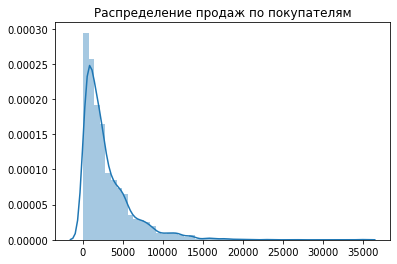

In [9]:
sns.distplot(retail_train[['user_id', 'sales_value']].groupby(by = 'user_id').sum())
plt.title('Распределение продаж по покупателям')
plt.plot()

[]

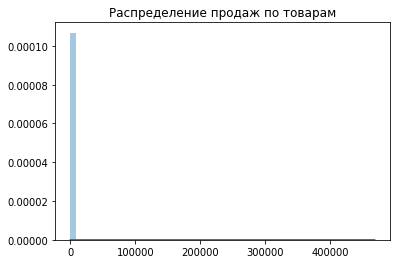

In [10]:
sns.distplot(retail_train[['item_id', 'sales_value']].groupby(by = 'item_id').sum())
plt.title('Распределение продаж по товарам')
plt.plot()

[]

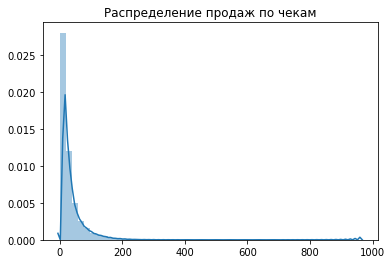

In [11]:
sns.distplot(retail_train[['basket_id', 'sales_value']].groupby(by = 'basket_id').sum())
plt.title('Распределение продаж по чекам')
plt.plot()

**Странным образом выглядит распределение продаж по товарам, следует поглубже изучить этот признак**

In [12]:
item_sales_distr = retail_train[['item_id', 'sales_value']].groupby(by = 'item_id').sum()
item_sales_distr.describe().T

,count,mean,std,min,25%,50%,75%,max
sales_value,"89,051.00",83.46,"1,628.72",0.00,3.50,10.78,46.11,"467,993.62"


In [13]:
item_sales_distr.sort_values(by = 'sales_value', ascending = False).head(5)

,sales_value
item_id,
6534178,"467,993.62"
6533889,"42,645.75"
1029743,"37,981.91"
6534166,"31,298.96"
1082185,"27,291.02"


**item  с артикулом '6534178' = выглядит крайне подозрительно, т.к. его продажи в 10 раз превышают ближайшего преследователя.
Посмотрим на него.**

In [14]:
product.loc[product['PRODUCT_ID'] == 6534178].T

,57221
PRODUCT_ID,6534178
MANUFACTURER,69
DEPARTMENT,KIOSK-GAS
BRAND,Private
COMMODITY_DESC,COUPON/MISC ITEMS
SUB_COMMODITY_DESC,GASOLINE-REG UNLEADED
CURR_SIZE_OF_PRODUCT,


## Кажется, мы заправка :)

In [15]:
sales_by_dept_raw = retail_train[['item_id', 'sales_value']].merge(product[['PRODUCT_ID', 'DEPARTMENT']], 
                                          how = 'left', 
                                          left_on = 'item_id', 
                                          right_on = 'PRODUCT_ID')
sales_by_dept = sales_by_dept_raw[['DEPARTMENT', 'sales_value']].groupby(by='DEPARTMENT').sum()
sales_by_dept['share'] = sales_by_dept['sales_value'] / sales_by_dept['sales_value'].sum()
sales_by_dept = sales_by_dept.reset_index()

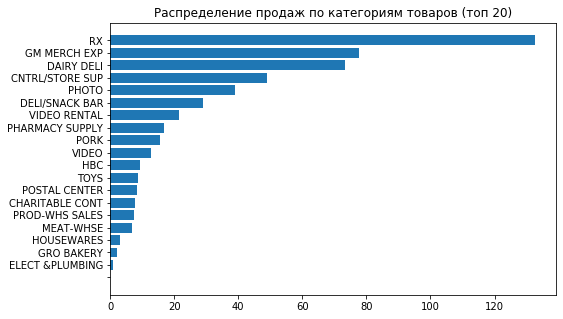

In [16]:

plt.figure(figsize=(8,5))
plt.barh(y = sales_by_dept.sort_values(by = 'share')['DEPARTMENT'].head(20) , 
         width = sales_by_dept.sort_values(by = 'share')['sales_value'].head(20)) # посмотрим распределение для первых 20 категорий
plt.title('Распределение продаж по категориям товаров (топ 20)')
plt.show()

## нет, мы не заправка :) Может, мы продуктовый магазин с бензином? ##
Или может это мы своим водителям бензин выдаем, чтобы они товар развозили... 
Посмотрим на количество товаров в категориях и заодно сделаем табличку с фичами для категорий

In [17]:
#считаем продажи товаров в категории
dept_product_sales = sales_by_dept_raw[['PRODUCT_ID', 
                                        'DEPARTMENT', 
                                        'sales_value']].groupby(by = ['PRODUCT_ID', 
                                                                      'DEPARTMENT']).sum().reset_index()
#считаем число продуктов в категории
number_of_products = dept_product_sales[['PRODUCT_ID', 
                                         'DEPARTMENT']].groupby(by = 'DEPARTMENT').count()\
.rename(columns = {'PRODUCT_ID': 'NUMBER OF PRODUCTS'})

#считаем число транзакций в категории
dept_product_transactions = sales_by_dept_raw[['DEPARTMENT',
                                               'sales_value']].groupby(by = ['DEPARTMENT']).count().reset_index()\
.rename(columns = {'sales_value': 'number of transactions'})



In [18]:
# джойним все созданные признаки
category_features =  sales_by_dept.merge(number_of_products.reset_index(), how = 'left',
                                        left_on = 'DEPARTMENT', right_on = 'DEPARTMENT')
category_features = category_features.merge(dept_product_transactions,
                                            how = 'left', left_on = 'DEPARTMENT', right_on = 'DEPARTMENT')
                                       
category_features = category_features.rename(columns = lambda x : x.lower())

In [19]:
category_features['avg transaction sum'] = category_features['number of transactions'] / category_features['sales_value']
category_features['transactions per item'] = category_features['number of transactions'] / category_features['number of products']
category_features.sort_values(by = 'sales_value', ascending = False).head(5)

,department,sales_value,share,number of products,number of transactions,avg transaction sum,transactions per item
17,GROCERY,"3,769,171.07",0.51,37895,1519030,0.40,40.09
10,DRUG GM,"972,647.61",0.13,30165,255983,0.26,8.49
33,PRODUCE,"515,212.52",0.07,3022,238525,0.46,78.93
21,MEAT,"509,933.08",0.07,2487,81794,0.16,32.89
20,KIOSK-GAS,"505,153.50",0.07,16,20407,0.04,"1,275.44"


## Для префильтра проведем RFM анализ##
но не для клиента как это обычно делается, а для продукта

- Recency - как давно соврешалась покупка
- Frequency - как часто совершались покупки
- Monetary - сколько денег они принесли

https://habr.com/ru/company/mindbox/blog/420915/

111 - хорошо, 333 - плохо

In [20]:
sales = retail_train.groupby('item_id').agg({'day':np.max, 'sales_value':np.sum, 'quantity':'count' }).reset_index()
# чем меньше значение в колонке day - тем старше самая свежая транзакция
# sales_value - будем считать на одну транзакцию
sales['sales_value'] /=  sales['quantity']
sales

,item_id,day,sales_value,quantity
0,25671,410,6.98,3
1,26081,250,0.99,1
2,26093,458,1.59,1
3,26190,238,1.54,1
4,26355,242,1.98,1
...,...,...,...,...
89046,17991689,659,2.49,1
89047,17991691,659,2.49,1
89048,18000012,663,6.65,3
89049,18024155,663,3.99,1


In [21]:
sales['R'] = 0

sales.loc[sales['day'] >  np.percentile(sales['day'], 66), 'R'] = 1
sales.loc[sales['day'] <= np.percentile(sales['day'], 66), 'R'] = 2
sales.loc[sales['day'] <= np.percentile(sales['day'], 33), 'R'] = 3 # Это будем отфильтровывать

sales['F'] = 0
sales.loc[sales['quantity'] >  np.percentile(sales['quantity'], 66), 'F'] = 1
sales.loc[sales['quantity'] <= np.percentile(sales['quantity'], 66), 'F'] = 2
sales.loc[sales['quantity'] <= np.percentile(sales['quantity'], 33), 'F'] = 3 #это не будем отфильтровывать,т.к. редко покупаемые, не значит неинтересные

sales['M'] = 0
sales.loc[sales['sales_value'] >  np.percentile(sales['sales_value'], 66), 'M'] = 1
sales.loc[sales['sales_value'] <= np.percentile(sales['sales_value'], 66), 'M'] = 2
sales.loc[sales['sales_value'] <= np.percentile(sales['sales_value'], 33), 'M'] = 3  # Это будем отфильтровывать

sales['RFM'] = sales['R'].astype(str) + sales['F'].astype(str) + sales['M'].astype(str)

sales['RFM'] = sales['RFM'].apply(lambda x: 'to_kill' if '3' in x else x) # помечаем на дальнейшую фильтрацию

In [22]:
sales['RFM'].value_counts()

to_kill    57523
112         8495
111         5087
221         5021
222         4091
121         2717
212         2286
122         2130
211         1701
Name: RFM, dtype: int64

In [23]:
pd.pivot_table(sales, index = ['RFM'], values = ['day', 'sales_value', 'quantity'],  
               aggfunc = {'day': np.mean, 'sales_value': np.mean, 'quantity': np.mean}).rename(columns = {'quantity': 'n_buys'})

,day,n_buys,sales_value
RFM,,,
111,649.30,67.14,7.28
112,651.63,84.36,2.97
121,641.32,3.95,8.56
122,642.21,4.08,3.06
211,542.08,19.91,7.74
212,535.38,26.04,2.99
221,518.84,3.58,8.56
222,514.05,3.65,3.06
to_kill,391.47,20.74,3.82


<BarContainer object of 9 artists>

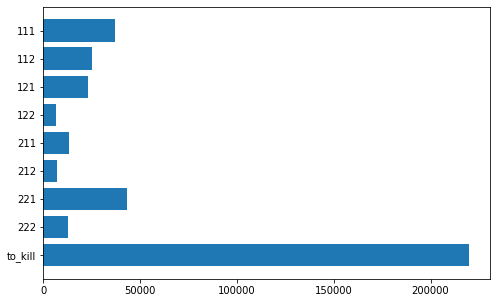

In [24]:
rfm_sls_distribution = sales.groupby('RFM').sum().reset_index()[['RFM', 
                                                                      'sales_value']].sort_values('RFM', 
                                                                                                  ascending=False)

plt.figure(figsize=(8,5))
plt.barh(y = rfm_sls_distribution['RFM'],
width = rfm_sls_distribution['sales_value'])

## Prefilter

In [25]:
def prefilter(data):

    #удаляем выброс (бензин)
    data.loc[data['sales_value'].isin(retail_train[['item_id', 'sales_value']].groupby('item_id').sum().reset_index()\
                                      .sort_values('sales_value', ascending = False)['item_id'].iloc[0:0]), 'RFM'] = 'to_kill'
    
    #1. Нельзя рекомендовать top 3 самых популярных товаров
    data.sort_values('quantity', ascending = False).loc[data['quantity'].isin(data['item_id'].iloc[0:3]), 'RFM'] = 'to_kill'
    
    #2.Нельзя рекомендовать товары, которые не продавались последние 12 месяцев
    data.loc[data['day'] < data['day'].max() - 365, 'RFM'] = 'to_kill'
    #3.Нельзя рекомендовать товары, с общим числом продаж < 50
    data.loc[data['quantity'] < 50, 'RFM'] = 'to_kill'
    #4.Нельзя рекомендовать товары, которые стоят < 1$
    data.loc[data['sales_value'] < 1, 'RFM'] = 'to_kill'
    return data

prefilter(sales)['RFM'].value_counts()

to_kill    83747
112         3566
111         1439
212          206
211           93
Name: RFM, dtype: int64

In [26]:
prefiltered_items = prefilter(sales)
prefiltered_items = prefiltered_items[prefiltered_items['RFM'] !='to_kill']
prefiltered_items



,item_id,day,sales_value,quantity,R,F,M,RFM
3020,279994,606,4.42,51,2,1,1,211
3460,397896,641,25.95,113,1,1,1,111
5613,818981,662,3.12,104,1,1,2,112
5634,819255,640,3.12,407,1,1,2,112
5641,819308,656,5.47,238,1,1,1,111
...,...,...,...,...,...,...,...,...
88087,16729299,660,3.35,65,1,1,2,112
88090,16729415,663,3.10,75,1,1,2,112
88341,16770156,663,2.78,58,1,1,2,112
88454,16809649,660,2.92,52,1,1,2,112


**Теперь отфильтруем эти записи в retail_train, остальное заменим фейковым товаром 999999999, а потом его отфильтруем**

In [27]:
retail_train.loc[~retail_train['item_id'].isin(prefiltered_items['item_id']),  'item_id'] = 999999999
retail_train = retail_train[retail_train['item_id']!=999999999]

## Feature ingeneering##
### Продукт. Новые признаки###

Для каждого из продуктов, которые мы будем рекомендовать, помимо уже созданных при помощи RFM фич сделаем коэффициенты наклона линии трендов за последние 10,20 и 40 недель

In [28]:
time_matrix = pd.pivot_table(retail_train[retail_train['week_no'] > retail_train['week_no'].max() - 20], index = 'item_id', columns = 'week_no', values = 'quantity', aggfunc = 'count').fillna(0)

In [29]:
def incline(raw_data, period = 20, index_ = 'item_id'):
    time_series = pd.pivot_table(raw_data[raw_data['week_no'] > raw_data['week_no'].max() - period], 
                                 index =  index_, 
                                 columns = 'week_no', 
                                 values = 'quantity', 
                                 aggfunc = 'count').fillna(0)
    
    tgs = []
    for i in time_series.values:
        mean_y= np.mean(i) # считаем среднее арифметическое продаж за period
        mean_x= np.mean(range(len(i))) # считаем среднее из кол-ва дат в period
        sum_ = 0
        sum_2 = 0
        for x, y in enumerate(i): # далее считаем тангенс угла наклона линии тренда
            sum_ += (x+1 - mean_x)*(y - mean_y)
            sum_2 +=(x - mean_x)**2
        
        tgs.append(sum_/sum_2)
    return pd.concat([time_series.reset_index()[index_], 
                      pd.Series(tgs, name = f'{period}w trend')], axis = 1)

In [30]:
#создадим df с трендом за 10 недель
product_trends = incline(retail_train, period = 10)
#нагенерим трендов за 20 и 40 недель
for i in [20, 40]:
    product_trends = product_trends.merge(incline(retail_train, period = i), 
                                         how = 'outer',
                                         left_on = 'item_id',
                                         right_on = 'item_id')

    
product_trends = product_trends.fillna(0).rename(columns = lambda x: 'prod ' + x if 'trend' in x else x)    
product_trends.head(3)



,item_id,prod 10w trend,prod 20w trend,prod 40w trend
0,279994,-0.10,-0.01,-0.01
1,397896,-0.18,-0.00,0.01
2,818981,0.05,-0.02,-0.02


In [31]:
prefiltered_items = prefiltered_items.merge(product_trends, how = 'left', 
                                            left_on = 'item_id', right_on = 'item_id').fillna(0)
prefiltered_items

,item_id,day,sales_value,quantity,R,F,M,RFM,prod 10w trend,prod 20w trend,prod 40w trend
0,279994,606,4.42,51,2,1,1,211,-0.10,-0.01,-0.01
1,397896,641,25.95,113,1,1,1,111,-0.18,-0.00,0.01
2,818981,662,3.12,104,1,1,2,112,0.05,-0.02,-0.02
3,819255,640,3.12,407,1,1,2,112,-0.44,-0.13,-0.09
4,819308,656,5.47,238,1,1,1,111,0.40,0.04,-0.03
...,...,...,...,...,...,...,...,...,...,...,...
5299,16729299,660,3.35,65,1,1,2,112,-0.18,0.25,0.15
5300,16729415,663,3.10,75,1,1,2,112,-0.12,0.33,0.18
5301,16770156,663,2.78,58,1,1,2,112,0.18,0.25,0.14
5302,16809649,660,2.92,52,1,1,2,112,-0.12,0.25,0.13


дополним продуктовую матрицу этими признаками

In [32]:
product_ext = product.merge(prefiltered_items, how = 'left', left_on = 'PRODUCT_ID', right_on = 'item_id')
product_ext.sort_values('prod 40w trend').head(3) 
product_ext = product_ext.drop(columns = 'item_id')

### Продукт-клиент. Новые признаки###
Сделаем фичи по взаимодействию клиента и товара

- доля покупок категории в корзине клиента
- доля покупок товара в корзине клиента
- тренды для пары клиент-товар
- тренды для пары клиент-категория товара




Для начала введем новый признак. Мы будем штрафовать старые продажи при помощи логарифма

In [33]:
retail_train['sales/log(day)'] = retail_train['sales_value'] * retail_train['day'].apply(lambda x: math.log2(x+1))
retail_train['sales/log(week)'] = retail_train['sales_value'] * retail_train['week_no'].apply(lambda x: math.log2(x+1))

In [34]:
retail_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,sales/log(day),sales/log(week)
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.00,0.00,1.39,1.39
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.00,0.00,1.57,1.57
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.00,0.00,2.99,2.99
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.00,0.00,2.50,2.50
31,1172,26985025264,1,930917,2,2.00,396,-0.78,946,1,0.00,0.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396726,1754,41653239425,663,1101010,1,3.02,343,-0.50,1609,95,0.00,0.00,28.31,19.89
2396728,1754,41653239425,663,5569230,4,10.00,343,-8.76,1609,95,0.00,0.00,93.75,65.85
2396729,2078,41653241879,663,871570,1,2.50,343,-1.29,2129,95,0.00,0.00,23.44,16.46
2396731,2078,41653241879,663,1074754,1,2.68,343,0.00,2129,95,0.00,0.00,25.13,17.65


In [38]:
# для начала разберемся с категориями
prod_cust_raw = retail_train.merge(product[['PRODUCT_ID', 'COMMODITY_DESC']], how = 'left', left_on = 'item_id', right_on = 'PRODUCT_ID')

#считаем общие продажи клиенту
sls_to_cust = prod_cust_raw[['user_id', 'sales/log(week)']].groupby(['user_id']).sum().reset_index()

#считаем продажи клиенту в разрезе категорий
sls_to_cust_category = prod_cust_raw[['user_id', 'COMMODITY_DESC', 'sales/log(week)']].groupby(['user_id', 'COMMODITY_DESC']).sum().reset_index()
#считаем долю
cust_category_feats = sls_to_cust_category.merge(sls_to_cust, how = 'left', left_on = 'user_id', right_on = 'user_id',
                                                suffixes = ('_ucat', '_user'))

cust_category_feats['cat_share in user'] = cust_category_feats['sales/log(week)_ucat'] / cust_category_feats['sales/log(week)_user']
cust_category_feats

,user_id,COMMODITY_DESC,sales/log(week)_ucat,sales/log(week)_user,cat_share in user
0,1,AIR CARE,13.13,"11,053.51",0.00
1,1,APPLES,141.64,"11,053.51",0.01
2,1,BACON,61.43,"11,053.51",0.01
3,1,BAG SNACKS,177.90,"11,053.51",0.02
4,1,BAKED BREAD/BUNS/ROLLS,"1,049.28","11,053.51",0.09
...,...,...,...,...,...
149603,2500,VEGETABLES - ALL OTHERS,13.62,"14,361.95",0.00
149604,2500,VEGETABLES - SHELF STABLE,106.00,"14,361.95",0.01
149605,2500,WAREHOUSE SNACKS,15.56,"14,361.95",0.00
149606,2500,WATER - CARBONATED/FLVRD DRINK,36.96,"14,361.95",0.00


In [39]:
# теперь тоже самое для пар товар-клиент

#считаем продажи клиенту в разрезе товаров
sls_to_cust_items = prod_cust_raw[['user_id', 'item_id', 'sales/log(week)']].groupby(['user_id', 'item_id']).sum().reset_index()
#считаем долю
cust_items_feats = sls_to_cust_items.merge(sls_to_cust, how = 'left', left_on = 'user_id', right_on = 'user_id')

cust_items_feats['item_share'] = cust_items_feats['sales/log(week)_x'] / cust_items_feats['sales/log(week)_y']
cust_items_feats

,user_id,item_id,sales/log(week)_x,sales/log(week)_y,item_share
0,1,823721,16.22,"11,053.51",0.00
1,1,823990,30.31,"11,053.51",0.00
2,1,826695,33.10,"11,053.51",0.00
3,1,827656,14.34,"11,053.51",0.00
4,1,829323,9.93,"11,053.51",0.00
...,...,...,...,...,...
444963,2500,13039424,25.44,"14,361.95",0.00
444964,2500,13115971,35.25,"14,361.95",0.00
444965,2500,13213057,15.37,"14,361.95",0.00
444966,2500,13382327,16.96,"14,361.95",0.00


In [40]:
#теперь соберем тренды по парам юзер-категория
user_category_trends = incline(prod_cust_raw, period = 20, index_ = ['user_id','COMMODITY_DESC'] )

#на эти операции не хватает памяти, придется ограничиться 20-недельным трендом:

#for i in [10, 40]:
#    category_trends = category_trends.merge(incline(prod_cust_raw, period = i, index_ = ['user_id','COMMODITY_DESC']), 
#                                         how = 'outer',
#                                         left_on = 'user_id',
#                                         right_on = 'user_id')

In [41]:
user_category_trends = user_category_trends.fillna(0).rename(columns = {'20w trend': 'user_cat 20w trend'})

In [42]:
user_category_trends

,user_id,COMMODITY_DESC,user_cat 20w trend
0,1,APPLES,0.02
1,1,BACON,0.01
2,1,BAG SNACKS,-0.01
3,1,BAKED BREAD/BUNS/ROLLS,0.01
4,1,BAKING MIXES,0.00
...,...,...,...
72792,2500,SUGARS/SWEETNERS,-0.00
72793,2500,TEAS,0.01
72794,2500,TICKETS,0.01
72795,2500,VALUE ADDED FRUIT,-0.01


In [43]:
#соединяем признаки в один df
user_items_feats = prod_cust_raw[['user_id', 'item_id', 'COMMODITY_DESC']].drop_duplicates()
user_items_feats = user_items_feats.merge(cust_category_feats, 
                                           how = 'left',
                                           left_on = ['user_id', 'COMMODITY_DESC'], 
                                           right_on = ['user_id', 'COMMODITY_DESC'])
user_items_feats = user_items_feats.merge(cust_items_feats, 
                                           how = 'left',
                                           left_on = ['user_id', 'item_id'], 
                                           right_on = ['user_id', 'item_id'])
user_items_feats = user_items_feats.merge(user_category_trends, 
                                           how = 'left',
                                           left_on = ['user_id', 'COMMODITY_DESC'], 
                                           right_on = ['user_id','COMMODITY_DESC'])


In [44]:
#to_delete = [i for i in user_items_feats.columns if 'sales/log' in i]
#user_items_feats = user_items_feats.fillna(0).drop([to_delete] , axis = 1)
user_items_feats = user_items_feats.fillna(0).drop('COMMODITY_DESC' , axis = 1)
user_items_feats

,user_id,item_id,sales/log(week)_ucat,sales/log(week)_user,cat_share in user,sales/log(week)_x,sales/log(week)_y,item_share,user_cat 20w trend
0,2375,1004906,632.26,"7,232.52",0.09,20.80,"7,232.52",0.00,-0.01
1,2375,1043142,1.57,"7,232.52",0.00,1.57,"7,232.52",0.00,0.00
2,2375,1085983,186.03,"7,232.52",0.03,158.96,"7,232.52",0.02,-0.03
3,1364,937406,68.30,"5,966.63",0.01,2.50,"5,966.63",0.00,0.03
4,1172,930917,33.61,"9,982.36",0.00,2.00,"9,982.36",0.00,-0.01
...,...,...,...,...,...,...,...,...,...
444963,845,1086727,92.55,"13,336.44",0.01,39.44,"13,336.44",0.00,0.01
444964,845,1110695,65.98,"13,336.44",0.00,17.71,"13,336.44",0.00,0.00
444965,845,12781828,398.36,"13,336.44",0.03,19.75,"13,336.44",0.00,0.12
444966,1754,1018740,215.22,"13,180.40",0.02,33.85,"13,180.40",0.00,0.03


### Клиент. Новые признаки###

соберем категориальный портрет пользователя. Данные у нас уже есть


In [45]:
user_feats = pd.pivot_table(cust_category_feats, index = 'user_id', 
                            columns = 'COMMODITY_DESC', 
                            values = 'cat_share in user', 
                            aggfunc = np.mean).reset_index()
user_feats.head(3)

COMMODITY_DESC,user_id,ADULT INCONTINENCE,AIR CARE,ANALGESICS,ANTACIDS,APPLES,BABY FOODS,BABY HBC,BACON,BAG SNACKS,...,UNKNOWN,VALUE ADDED FRUIT,VALUE ADDED VEGETABLES,VEGETABLES - ALL OTHERS,VEGETABLES - SHELF STABLE,VEGETABLES SALAD,WAREHOUSE SNACKS,WATER,WATER - CARBONATED/FLVRD DRINK,YOGURT
0,1,nan,0.00,nan,nan,0.01,nan,nan,0.01,0.02,...,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan
1,2,nan,nan,nan,nan,0.02,nan,nan,0.00,0.02,...,nan,nan,nan,nan,nan,nan,nan,nan,0.01,0.00
2,3,nan,nan,nan,nan,nan,nan,nan,nan,0.02,...,nan,nan,nan,nan,0.00,nan,nan,nan,0.01,0.00


In [46]:
# так выглядит Топ10 товаров корзины пользователя 1:
user_feats[user_feats['user_id'] == 1].T.sort_values(0, ascending = False).head(10)

,0
COMMODITY_DESC,
user_id,1.00
BAKED BREAD/BUNS/ROLLS,0.09
SOFT DRINKS,0.07
REFRGRATD JUICES/DRNKS,0.06
LUNCHMEAT,0.06
HEAT/SERVE,0.06
CHEESE,0.05
FRZN NOVELTIES/WTR ICE,0.04
BATH TISSUES,0.04


# Модель#

In [47]:
#импорт библиотек и настройка метрик
import scipy
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


from scipy.sparse import csr_matrix

# Модель второго уровня
from lightgbm import LGBMClassifier

#from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

def recall_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)
    
    return recall


def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    return precision

## train_test_valid split

In [49]:
# для двухуровневой модели: ALS будем считать на test_size_weeks, бустинг на valid_size_weeks

valid_size_weeks = 3
test_size_weeks = 6

data_train = retail_train[retail_train['week_no'] < retail_train['week_no'].max() - (test_size_weeks + valid_size_weeks)]

data_test = retail_train[(retail_train['week_no'] >= retail_train['week_no'].max() - (test_size_weeks + valid_size_weeks)) &
                         (retail_train['week_no'] < retail_train['week_no'].max() - valid_size_weeks)]

data_valid = retail_train[(retail_train['week_no'] >= retail_train['week_no'].max() - valid_size_weeks)]



In [50]:
#Первый уровень модели
#подготовим таблицу с фактом покупки (actual) для записи результатов и расчета метрик
#data_test_filtered = 

result = data_test.groupby('user_id')['item_id'].unique().reset_index() #[data_test['item_id'] != 999999999]
result.columns=['user_id', 'actual']

#добавим персональные товары продававшиеся на трейне
sold_in_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
sold_in_train.columns=['user_id', 'sold_in_train']

result = result.merge(sold_in_train, how = 'left', left_on = 'user_id', right_on = 'user_id')
result

,user_id,actual,sold_in_train
0,1,"[865456, 872137, 878285, 912806, 940947, 98389...","[845307, 852014, 856942, 912676, 940947, 99102..."
1,2,"[839656, 866211, 893867, 901062, 947798, 99065...","[854852, 930118, 5567582, 5568489, 5569230, 93..."
2,4,"[970760, 1035676, 13115703, 831063, 891423, 90...","[836163, 891423, 907631, 910109, 939907, 94076..."
3,6,"[1024306, 6548453, 835394, 970030, 1098844, 83...","[851819, 851903, 863447, 876232, 907099, 97003..."
4,7,"[914190, 938863, 993638, 1106523, 5572738, 885...","[893400, 1029743, 1040183, 1068504, 1074172, 1..."
...,...,...,...
2062,2496,"[831509, 820321, 825659, 839243, 842783, 86545...","[871756, 899624, 916122, 999270, 1000753, 1056..."
2063,2497,"[916993, 949991, 965430, 970924, 977867, 98128...","[1037840, 1052294, 5569230, 8090537, 1022428, ..."
2064,2498,"[865511, 962991, 1102358, 5564901, 844991, 940...","[901776, 1005186, 1070820, 9677846, 1044500, 9..."
2065,2499,"[882308, 830887, 833458, 865992, 869322, 89962...","[838186, 883665, 932949, 933835, 1067695, 1132..."


In [51]:
#Добавим Baseline - самые продающиеся товары
result['baseline'] = np.nan

top_popular = data_train.groupby(['item_id']).agg({'sales/log(week)':np.sum})\
                    .sort_values(by='sales/log(week)', ascending = False).reset_index().head(100)['item_id'].unique()




result['baseline'] = result['baseline'].apply(lambda x: top_popular)

#baseline = data_test.groupby('item_id')
result.head(3)

,user_id,actual,sold_in_train,baseline
0,1,"[865456, 872137, 878285, 912806, 940947, 98389...","[845307, 852014, 856942, 912676, 940947, 99102...","[6534178, 6533889, 1029743, 6534166, 916122, 6..."
1,2,"[839656, 866211, 893867, 901062, 947798, 99065...","[854852, 930118, 5567582, 5568489, 5569230, 93...","[6534178, 6533889, 1029743, 6534166, 916122, 6..."
2,4,"[970760, 1035676, 13115703, 831063, 891423, 90...","[836163, 891423, 907631, 910109, 939907, 94076...","[6534178, 6533889, 1029743, 6534166, 916122, 6..."


In [52]:
result.loc[result['sold_in_train'].isnull(), 'sold_in_train'] = result['baseline']
result.apply(lambda row: recall_at_k(row['sold_in_train'], row['actual'], k=100), axis=1).mean()

0.30203727445966205

##  USER ITEM матрица ##

In [53]:
user_item_matrix = pd.pivot_table(data_train, index = 'user_id', #[data_train['item_id'] != 999999999]
                                  columns = 'item_id', 
                                  values = 'sales/log(week)', #суммируем оштрафованные за давность продажи
                                  aggfunc = np.sum,
                                  fill_value = 0).astype(float)



In [54]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [55]:
user_item_matrix = scipy.sparse.csr_matrix(user_item_matrix)

## ALS

In [56]:
model = AlternatingLeastSquares(factors=500, 
                                regularization=0.01,
                                iterations=50, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

In [57]:
def get_recommendations(user, model, N=5):
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items= np.array([999999999]),
                                    recalculate_user=True)]

    return res

In [58]:
#Новым юзерам будем рекомендовать бэйслайн, поэтому они здесь не будут нужны
new_users = result[~result['user_id'].isin(userids)]
old_users = result[result['user_id'].isin(userids)]

## Опорная модель первого уровня##

Получим рекомендации для каждого пользователя в тестовой базе

In [60]:
%%time
old_users['als_100'] = old_users['user_id'].apply(lambda x: get_recommendations(x, model=model, N=100))

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Wall time: 4min 42s


#### Recall@100
Нам нужен Recall@100 т.к. для модели второго уровня важно, что в обучающую выборку попало как можно больше релевантных позиций

In [61]:
old_users.apply(lambda row: recall_at_k(row['als_100'], row['actual'], k=100), axis=1).mean()

0.37437972977884837

In [63]:
#Добавим в таблицу с результатами реколл100 для каждой строки
old_users['als_recall'] = old_users.apply(lambda row: recall_at_k(row['als_100'], row['actual'], k=100), axis=1)

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
#там где реколл меньше бэйслайн реколл (0.18) будем обучать вторую модель на топ популярных
old_users.loc[old_users['als_recall'] <= 0.18, 'comb_rec'] = old_users['baseline']
old_users.loc[old_users['comb_rec'].isnull(), 'comb_rec'] = old_users['als_100']

#считаем recall@100
old_users.apply(lambda row: recall_at_k(row['comb_rec'], row['actual'], k=100), axis=1).mean()

C:\Users\MI\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\MI\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.38745532385629955

## Второй уровень##
### Готовим валидационные данные###

In [99]:
test_data = data_valid.groupby('user_id')['item_id'].unique().reset_index()

In [100]:
test_data

,user_id,item_id
0,1,"[856942, 865456, 907957, 914190, 951954, 97158..."
1,3,[920626]
2,6,"[1104227, 870315, 956672, 6979393, 909479, 948..."
3,7,"[898068, 909714, 993838, 1106523, 1108844, 111..."
4,8,"[835098, 872137, 5569230, 5569471, 13071586, 8..."
...,...,...
1938,2496,[6534178]
1939,2497,"[1016709, 9835695, 871756, 1068719, 1115187, 1..."
1940,2498,"[901776, 914190, 958382, 972437, 1070820, 1022..."
1941,2499,"[902396, 914190, 1060872, 1106091, 1119993, 55..."


In [101]:
test_data = test_data[test_data['user_id'].isin(userids)]
test_data_new_users = test_data[~test_data['user_id'].isin(userids)]

In [102]:
test_data['als_100'] = test_data['user_id'].apply(lambda x: get_recommendations(x, model=model, N=100))

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:

#посчитаем целевую метрику на первом уровне обучения

test_data.apply(lambda row: precision_at_k(row['als_100'], row['item_id'], k=5), axis=1).mean()

0.08875128998967984

## Датасет для второго уровня

In [239]:
from lightgbm import LGBMRanker

def X_creator(first_stage_results): #first_stage_results - на трейне, sales_results - на тесте
    
    # Создаем признаковое пространство X_train
    X_ = pd.DataFrame({'user_id':first_stage_results.user_id.values.repeat(len(first_stage_results.als_100[0])),
                 'item_id':np.concatenate(first_stage_results.als_100.values)})
    
    # фичи для продуктов
    product_ext.columns = [x.lower() for x in product_ext.columns]
    product_ext.rename(columns = {'PRODUCT_ID': 'item_id'}, inplace = True)
    X_ = X_.merge(product_ext, how = 'left', left_on = 'item_id', right_on = 'item_id')
    
    # фичи для юзеров
    X_ = X_.merge(user_feats, how = 'left', left_on = 'user_id', right_on = 'user_id')
    
    # фичи для взаимодействий
    X_ = X_.merge(user_items_feats, how = 'left', left_on = ['user_id','item_id'], right_on = ['user_id','item_id']).fillna(0)
    
    # Преобразуем категориальные фичи    
    categorical_feats = ['manufacturer', 'department',  'brand',
                         'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'r', 'f', 'm', 'rfm']
    
    X_[categorical_feats] = X_[categorical_feats].astype('category')   
    return X_
    
def X_y_creator(X_, sales_results):
    # Целевая переменная
    target = sales_results.groupby(['user_id','item_id']).agg({'sales/log(week)':np.sum}).reset_index()
    target.rename(columns = {'sales/log(week)': 'target'}, inplace = True)
    target['target'] = 1
        
    # Джойним
    X_ = X_.merge(target, how = 'left', left_on = ['user_id','item_id'], right_on = ['user_id','item_id'])
    X_.loc[X_['target'].isnull(), 'target'] = 0
    # Разбиваем    
    y_ = X_['target']
    X_ = X_.drop(columns = 'target')
    
    #группировщик
    X_['num'] = np.arange(len(X_))
    group_ = X_[['user_id', 'num']].groupby('user_id', sort=False).max()['num'].values
    groups_lgbm = np.concatenate((np.array([group_[0]+1]), group_[1:] - group_[:-1]))
        
    return X_, y_, groups_lgbm

def X_columns_name_cleaner(X_):    
    #очистка имен столбцов от json символов
    import re
    cols = X_.columns.to_list()

    forbid = ['&', '/', '-',':']
    for idx, i in enumerate(cols):    
        for j in forbid:
            if j in i:
                i = re.sub(j, '_', i)
                cols[idx] = i            
    X_.columns = cols
    
    return X_   


In [240]:

X_train, y_train, groups_ = X_y_creator(X_creator(old_users), data_test)
X_train = X_columns_name_cleaner(X_train)

## Модель второго уровня - LGBM Ranker

In [241]:
?LGBMRanker

In [242]:
lgb = LGBMRanker(n_estimators=300, max_depth = 2, random_state = 42, silent=True)
lgb.fit(X_train, y_train, group=groups_,
        eval_set=[(X_train, y_train)], eval_group=[groups_], 
        eval_metric=['ndcg'],
        eval_at=[5, 10 ], early_stopping_rounds=50)

[1]	training's ndcg@5: 0.458749	training's ndcg@10: 0.484094
Training until validation scores don't improve for 50 rounds
[2]	training's ndcg@5: 0.579231	training's ndcg@10: 0.596998
[3]	training's ndcg@5: 0.625733	training's ndcg@10: 0.635242
[4]	training's ndcg@5: 0.644636	training's ndcg@10: 0.647418
[5]	training's ndcg@5: 0.643981	training's ndcg@10: 0.647989
[6]	training's ndcg@5: 0.658514	training's ndcg@10: 0.656792
[7]	training's ndcg@5: 0.658614	training's ndcg@10: 0.657874
[8]	training's ndcg@5: 0.664952	training's ndcg@10: 0.664015
[9]	training's ndcg@5: 0.664238	training's ndcg@10: 0.664561
[10]	training's ndcg@5: 0.67219	training's ndcg@10: 0.670034
[11]	training's ndcg@5: 0.675818	training's ndcg@10: 0.671757
[12]	training's ndcg@5: 0.678534	training's ndcg@10: 0.674023
[13]	training's ndcg@5: 0.681328	training's ndcg@10: 0.677185
[14]	training's ndcg@5: 0.686	training's ndcg@10: 0.679666
[15]	training's ndcg@5: 0.689919	training's ndcg@10: 0.683078
[16]	training's ndcg@5

[132]	training's ndcg@5: 0.767625	training's ndcg@10: 0.759963
[133]	training's ndcg@5: 0.767768	training's ndcg@10: 0.760171
[134]	training's ndcg@5: 0.767895	training's ndcg@10: 0.760499
[135]	training's ndcg@5: 0.767382	training's ndcg@10: 0.760703
[136]	training's ndcg@5: 0.767587	training's ndcg@10: 0.761023
[137]	training's ndcg@5: 0.768021	training's ndcg@10: 0.761153
[138]	training's ndcg@5: 0.768423	training's ndcg@10: 0.76144
[139]	training's ndcg@5: 0.768764	training's ndcg@10: 0.761573
[140]	training's ndcg@5: 0.768952	training's ndcg@10: 0.761842
[141]	training's ndcg@5: 0.769779	training's ndcg@10: 0.762139
[142]	training's ndcg@5: 0.769556	training's ndcg@10: 0.761904
[143]	training's ndcg@5: 0.769894	training's ndcg@10: 0.762191
[144]	training's ndcg@5: 0.770247	training's ndcg@10: 0.762712
[145]	training's ndcg@5: 0.770522	training's ndcg@10: 0.762949
[146]	training's ndcg@5: 0.770288	training's ndcg@10: 0.763
[147]	training's ndcg@5: 0.770692	training's ndcg@10: 0.763

[262]	training's ndcg@5: 0.795671	training's ndcg@10: 0.78373
[263]	training's ndcg@5: 0.795902	training's ndcg@10: 0.783769
[264]	training's ndcg@5: 0.795812	training's ndcg@10: 0.783826
[265]	training's ndcg@5: 0.795812	training's ndcg@10: 0.783826
[266]	training's ndcg@5: 0.796064	training's ndcg@10: 0.784128
[267]	training's ndcg@5: 0.796075	training's ndcg@10: 0.784125
[268]	training's ndcg@5: 0.796361	training's ndcg@10: 0.784515
[269]	training's ndcg@5: 0.796415	training's ndcg@10: 0.784723
[270]	training's ndcg@5: 0.796338	training's ndcg@10: 0.784502
[271]	training's ndcg@5: 0.796503	training's ndcg@10: 0.784573
[272]	training's ndcg@5: 0.796785	training's ndcg@10: 0.784827
[273]	training's ndcg@5: 0.796795	training's ndcg@10: 0.784809
[274]	training's ndcg@5: 0.797132	training's ndcg@10: 0.784798
[275]	training's ndcg@5: 0.797544	training's ndcg@10: 0.785033
[276]	training's ndcg@5: 0.797471	training's ndcg@10: 0.785382
[277]	training's ndcg@5: 0.797293	training's ndcg@10: 0.

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=2,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
           random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [244]:
def model_result(X_, eval_data):
        
        #добавляем к X_ предсказания модели   
        evaluation_result = pd.concat([X_[['user_id', 'item_id']], pd.Series(lgb.predict(X_), name='relevance_score')],axis=1)
        tmp = pd.DataFrame(columns = evaluation_result.columns)
        
        #собираем топ 5 из evaluation_results отсортированного по relevance score
        for user in evaluation_result['user_id'].unique():
            tmp = pd.concat([tmp, 
                             evaluation_result[evaluation_result['user_id'] == user]\
                             .sort_values('relevance_score', ascending = False).head(5)])
        
        #группируем рекомендации по юзерам
        result_table = tmp.groupby('user_id')['item_id'].unique().reset_index()
        result_table.rename(columns = {'item_id': 'model_2_recs'}, inplace = True)

        #группируем данные по продажам по юзерам
        eval_data = eval_data.groupby('user_id')['item_id'].unique().reset_index()
        eval_data.rename(columns = {'item_id': 'actual'}, inplace = True)

        #объединяем рекомендации и продажи
        eval_data = eval_data.merge(result_table, how = 'left', left_on = 'user_id', right_on = 'user_id')
        
        #для новых юзеров добавляем бэйслайн - топ популярных
        eval_data['baseline'] = np.nan
        eval_data['baseline'] = eval_data['baseline'].apply(lambda x: top_popular)
        eval_data.loc[eval_data['model_2_recs'].isnull(), 'model_2_recs'] = eval_data['baseline']

        #считаем метрику
        prec_at_5 = eval_data.apply(lambda row: precision_at_k(row['model_2_recs'], row['actual'], k=5), axis=1).mean()
        
        return eval_data, prec_at_5
    

In [245]:
train_results, train_prec_at_5 = model_result(X_train, data_test)
train_prec_at_5

0.5683599419448456

## Тест на валидационных данных

In [246]:
X_valid = X_creator(test_data)
X_valid['num'] = np.arange(len(X_valid))

### Оцениваем результат

In [249]:
valid_results, valid_prec_at_5 = model_result(X_valid, data_valid)
valid_prec_at_5

0.4348944930519815

In [261]:
valid_results[['user_id', 'model_2_recs']].set_index('user_id').head(5)

,model_2_recs
user_id,
1,"[856942, 9297615, 940947, 9655212, 5577022]"
3,"[822407, 921345, 1092937, 1127025, 910032]"
6,"[1098844, 1029743, 863447, 6534178, 970030]"
7,"[1122358, 1106523, 1126899, 5568378, 6034857]"
8,"[872137, 1004906, 1005186, 1029743, 1068719]"


### Готовим выгрузку

In [258]:
valid_results[['user_id', 'model_2_recs']].set_index('user_id')\
                                    .to_csv(r'C:\Users\MI\Downloads\course_project\recommend systems\result.csv', sep = ',')